[![logo](https://climate.copernicus.eu/sites/default/files/custom-uploads/branding/LogoLine_horizon_C3S.png)](https://climate.copernicus.eu)

# Calculating agroclimatic indicators under climate change scenarios

Agroclimatic indicators summarize the conditions during the growing season or during particular crop stages within a season. An example of an agroclimatic indicator is the number of growing degree days which is important to determine if a given crop will be able to complete its growth cycle for a particular location. Other examples are the cumulated amount of precipation during the cropping season or the number of days with high temperatures during a sensitive phenological stage such as flowering. Climate change will have an impact on the weather conditions during the growing season. Agroclimatic indicators are therefore an important tool to summarize the impact of climate change on the growing conditions of the crop. 

This notebook serves as an example of how to use data from the [Copernicus Climate Datastore](https://cds.climate.copernicus.eu/) to compute an agroclimatic indicator. Moreover, we will use data from the past as well as a climate scenario to visualize the change in the indicator value as a result of climate change. The notebook focuses on computing the ["Warm and wet days" (WW) indicator](https://confluence.ecmwf.int/pages/viewpage.action?pageId=278550975). The agronomic background is that warm and wet conditions are conducive for fungal diseases to develop.

## Learning objectives

The overall learning objective is to demonstrate how to compute the agroclimatic indicators in the current [CDS catalogue entry](https://doi.org/10.24381/cds.dad6e055) with the new climate scenarios from [CMIP6](https://confluence.ecmwf.int/display/CKB/CMIP6%3A+Global+climate+projections#CMIP6:Globalclimateprojections-Models).

More specifically, the learning objectives are:

1. Downloading relevant datasets from the Copernicus Climate Datastore (CDS)
2. Performing operations like bias correction and regridding of climate model data
3. Computing an agroclimatic indicator with the `ICCLIM` library
4. Visualizing and understanding the impact of the climate change on agroclimatic indices

## Target audience

Anyone with an interest in assessing and understanding the impact of climate change on agriculture. Particularly, policy makers, planners and managers in the agro value chain who operate on regional scales. The datasets available for this study are not applicable at the farm scale.

## Limitation of this notebook

This notebook implements the complete processing chain for computing the Warm & Wet indicator. However, given the limitations in computing time and amount of data that have to be retrieved there are several simplifications that have been implemented:

1. We download weather data for a limited number of years. For the past weather, we only use 5 years of data while for the future weather conditions we only retrieve 1 year.
2. We use data from only 1 climate model.
3. We limited the processing to a relatively small region, in this case the Iberian peninsula.
4. We do not take the crop calendar into account, instead we compute the indicator over the entire year.

For true impact studies on climate change and agriculture this will not be sufficient. It is strongly advised to use longer time-series (30 years) and multiple climate models in order to estimate uncertainty and effect of weather variability. Moreover, the cropping calendar of different crops should be taken into account as well as expected changes in crop management (e.g. sowing date, other varieties) under future weather by farmers.

## Outline

1. Installing and importing necessary libraries
2. Downloading data:
   1. Connecting to the CDS
   2. Historical daily weather data from a reanalysis dataset called [AgERA5](https://cds.climate.copernicus.eu/datasets?q=agera5])
   3. Historical daily weather data from a [CMIP6](https://confluence.ecmwf.int/display/CKB/CMIP6%3A+Global+climate+projections#CMIP6:Globalclimateprojections-Models) climate model.
   4. Future daily weather data from the same climate model for the SSP8.5 climate scenario.
3. Load and prepare AgERA56 and CMIP6 data:
    1. Loading data with IRIS
    2. Regridding with IRIS
    3. Conversion of units 
    4. Bias adjusting the climate projection
4. Generating the agroclimatic indicator
    1. Compute the W&W days indicators
    2. Analysing the results

## 1. Installing and importing necessary libraries

Before we can begin, we need to set up our python environment with required libraries.
These include:
- `iris` for climate data reading and regridding
- `cdsapi` for executing API requests to the Climate Data Store
- `ibicus` for applying bias correction techniques
- `xarray`, `numpy` and `dask` for working with N-Dimensional arrays and corresponding NetCDF files
- `icclim` for generating climate indices
- `matplotlib` and `cartopy` for plotting

First we install and import the required libraries. Depending on the speed of your system and internet connection this can take a few minutes. Note that nothing is displayed in the notebook output pane until the install is finished.

In [ ]:
# Install iris via conda, this can take several minutes. 
# Output from conda is shown only after installation is finished, so nothing "happens" at first.
%conda install -c conda-forge iris==3.11.0 -y

In [ ]:
# Install other required libraries via pip
# Output from pip is shown only after installation is finished, so nothing "happens" at first.
%pip install cdsapi ibicus==1.1.1 xarray==2023.10.1 icclim==6.5.0 numpy==1.26.4 xclim==0.47.0

In [2]:
import os
from pathlib import Path
from types import SimpleNamespace
import zipfile
import logging
import concurrent.futures

import numpy as np
import cdsapi
import xarray as xr        
import ibicus
import iris
import matplotlib as mpl
from matplotlib import pyplot as plt
import icclim
import cartopy.crs as ccrs
import dask

## 2. Downloading data

The notebook will contact the Copernicus climate datastore ([CDS](https://cds.climate.copernicus.eu/)) to download meteorological data. Three sets of weather data are downloaded:
 - Historical daily weather data from a reanalysis dataset called [AgERA5](https://cds.climate.copernicus.eu/datasets?q=agera5])
 - Historical daily weather data from a climate model (in this case we use data from the `ec_earth3_cc` model).
 - Future daily weather data from the same climate model for the SSP8.5 climate scenario.

**Important**: 

- Before you can download you will need to provide your CDS API key. You need to create an account on the [CDS](https://cds.climate.copernicus.eu/) first. You can find your API key under the account settings.
- You need to accept the general conditions of the CDS. This is done most easily by downloading a dataset (does not matter which) and selecting the "accept license" button on the interface.


While selected date ranges for historical and projected climate data were kept as small as possible for demonstration purposes, the duration of the downloading procedure can vary, depending on the state of CDS API service. Downloading the date ranges and variables selected in this notebook by default should take about 60 minutes in total, and require at least 350 MB of available storage space.

First, let us prepare the directory structure for storing the downloaded data. 

*Choose the parent directory where all data will be stored*:

In [3]:
PARENT_PATH = "./Data/agroclim_WW" 

In [4]:
# Define the directory structure, starting at the parent path
parent_path = Path(PARENT_PATH)

# Historical data directories
hist_model_path = parent_path / "historical_model_data"
hist_obs_path = parent_path / "historical_observation_data"

# Future projection data directory
future_model_path = parent_path / "future_model_data"

# Create the above-defined directories
hist_model_path.mkdir(parents=True, exist_ok=True)
hist_obs_path.mkdir(parents=True, exist_ok=True)
future_model_path.mkdir(parents=True, exist_ok=True)

### 2A. Connect to the CDS
To request climate data from the Climate Data Store (CDS) we will use the CDS API. We make use of the option to manually set the CDS API credentials. 

*To obtain these, first register or login to the CDS (http://cds.climate.copernicus.eu), then visit https://cds.climate.copernicus.eu/api-how-to. Add your API key after the `your_key` variable below.*

In [5]:
your_key = 'xxxxxxxx-xxxx-xxxx-xxxx-xxxxxxxxxxxx' # Enter your key here
cdsapi_key = None if your_key.startswith("xxxx") else your_key

# Initialise CDS API client
cds_api = cdsapi.Client(key=cdsapi_key)

2025-07-15 09:38:01,097 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-15 09:38:01,097 [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


#### Defining download details

Now let us define the details of the data we are interested in. This includes climate model and variable names as well as the time ranges and spatial boundaries:

**Model:** Climate projection model used for estimating future climate.
* A detailed overview of currently available models can be found on the [CMIP6 documentation page](https://confluence.ecmwf.int/display/CKB/CMIP6%3A+Global+climate+projections#CMIP6:Globalclimateprojections-Models)
  
**Experiment:** Shared Socioeconomic Pathway (SSP) Experiment to use for the climate projection
* See [CMIP6 documentation page](https://confluence.ecmwf.int/display/CKB/CMIP6%3A+Global+climate+projections#CMIP6:Globalclimateprojections-Experiments) for details

**Variable:** Climate variables which will be necessary for computing a selected agroclimatic indicator.

**Historical data date range**: List of years to use for climate projection model debiasing reference.

**Future data date range**: List of years in the future we want to compute a projected agroclimatic index for.

**Area of interest**: Bounds of an area we are interested in.

An overview of available options for all relevant parameters and their corresponding string values can be found in the [CDS user interface](https://cds.climate.copernicus.eu/datasets/projections-cmip6?tab=download). Note that at the bottom of the page you can find the code for the API request  which you can use in your own download scripts.

In [6]:
# Choose model and future projection experiment
MODEL = 'ec_earth3_cc'
EXPERIMENT_FUTURE = 'ssp5_8_5'

# Choose climate variables to extract
VARIABLES = [
    "near_surface_air_temperature", 
    "precipitation"
]

# Choose area to extract [N, W, S, E]
AREA = [44, -10, 36, 1] # Approximate bounds of the Iberian Peninsula

# Choose years to download for historical data
# 2005 - 2009
YEARS_HIST = [f"{s:04}" for s in range(2005,2010)]

# Choose years to download for future projection data
YEARS_FUTURE = ["2040"]

# Choose all months to download for historical data
ALL_MONTHS = [f"{s:02}" for s in range(1, 13)]

# Choose all days to download for historical data
ALL_DAYS = [f"{s:02}" for s in range(1,32)]

### 2B. Downloading historical data from reanalysis (AgERA5)

AgERA5 data has to be downloaded for each year and each statistic separately to keep the request size manageable. Nevertheless we can use threading to make parallel requests to the CDS and speed up the downloads considerably.

After unzipping we get a NetCDF file for each day and variable.

In [7]:
def download_agera5(inputs):
    """Download AgERA5 data for given inputs and return the downloaded filename and path 
    for extraction
    """
    variable, statistic, year, filepath, extract_path = inputs

    # If the file already exists, we do not have to download it again.
    if filepath.exists():
        print(f"{filepath} already exists. Skipping...")
    else:
        print(f"Starting download for {variable} for {year}.")
        req = {"variable": variable,
               "year": f"{year}",
               "month": ALL_MONTHS,
               "day": ALL_DAYS,
               "area": AREA,
               "version": "2_0"
              }
        if statistic != "":
            req["statistic"] = statistic
    
        cds_api.retrieve(
            name = "sis-agrometeorological-indicators",
            request = req,
            target = filepath
        )
        print(f"Downloaded {variable} for {year} to {filepath}.")

    return (filepath, extract_path)

def generate_cds_inputs():
    """Generates the list of inputs for CDS requests
    """
    # Select the AgERA5 variables and corresponding statistics
    variables_AGERA5 = [("2m_temperature", "24_hour_mean"), ("precipitation_flux","")]
    
    # Generate a list of inputs for the CDS requests that have to be downloaded
    all_downloads = []
    for variable, statistic in variables_AGERA5:
        for year in YEARS_HIST:
            # Choose a filename for the historical observation data
            filename = f"{variable}_{statistic}_historical_obs_{year}.zip"
            filepath = hist_obs_path / filename
            
            # Choose a directory name for extracting the downloaded data into
            extract_dir = f"{variable}_{statistic}_historical_obs_extracted"
            extract_path = hist_obs_path/extract_dir
    
            all_downloads.append((variable, statistic, year, filepath, extract_path))
    
    return all_downloads

# Switch off logging to avoid a large amount of output on screen
logging.disable(logging.CRITICAL)

# Run a parallel download of AgERA5 data
all_downloads = generate_cds_inputs()
with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
    downloaded_sets = executor.map(download_agera5, all_downloads)

# Extract the downloaded files
for filepath, extract_path in downloaded_sets:
    # Extract the zip file
    # ("//?/" to prevent issues with long file paths in Windows)
    with zipfile.ZipFile(r"//?/"+f"{filepath.resolve()}", 'r') as zip_ref:
        zip_ref.extractall(r"//?/"+f"{extract_path.resolve()}")  

Data\agroclim_WW\historical_observation_data\2m_temperature_24_hour_mean_historical_obs_2005.zip already exists. Skipping...Data\agroclim_WW\historical_observation_data\2m_temperature_24_hour_mean_historical_obs_2006.zip already exists. Skipping...

Data\agroclim_WW\historical_observation_data\2m_temperature_24_hour_mean_historical_obs_2007.zip already exists. Skipping...
Data\agroclim_WW\historical_observation_data\2m_temperature_24_hour_mean_historical_obs_2008.zip already exists. Skipping...
Data\agroclim_WW\historical_observation_data\2m_temperature_24_hour_mean_historical_obs_2009.zip already exists. Skipping...
Data\agroclim_WW\historical_observation_data\precipitation_flux__historical_obs_2005.zip already exists. Skipping...
Data\agroclim_WW\historical_observation_data\precipitation_flux__historical_obs_2006.zip already exists. Skipping...
Data\agroclim_WW\historical_observation_data\precipitation_flux__historical_obs_2007.zip already exists. Skipping...
Data\agroclim_WW\histori

### 2C. Downloading historical climate model data

Executing the cell below will retrieve the historical climate model data for the selected set of climate variables:

In [8]:
# Walk through the variables that we selected
for variable in VARIABLES:
    
    # Create a filename for the historical model data
    filename = f"{variable}_historical_{MODEL}.zip"
    filepath = hist_model_path / filename

    # Create a directory name for extracting the downloaded data into
    extract_dir = f"{variable}_historical_{MODEL}_extracted"
    extract_path = hist_model_path/extract_dir

    # if the file already exists you receive a messsage and we can skip it.
    if filepath.exists():
        print(f"{filepath} exists. Skipping download...")
    else:
        print(f"Downloading {variable}...", end="")
        # Download the zip file with selected data
        cds_api.retrieve(
            name = 'projections-cmip6',
            request = {
                "temporal_resolution": "daily",
                "model": MODEL,
                "experiment": "historical",
                "variable": variable,
                "year": YEARS_HIST,
                "month": ALL_MONTHS,
                "day": ALL_DAYS,
                "area": AREA
            },
            target = filepath
        )
        print("Done.")

    # Extract the zip file
    # ("//?/" to prevent issues with long file paths in Windows)
    with zipfile.ZipFile(r"//?/"+f"{filepath.resolve()}", 'r') as zip_ref:
        zip_ref.extractall(r"//?/"+f"{extract_path.resolve()}")

Data\agroclim_WW\historical_model_data\near_surface_air_temperature_historical_ec_earth3_cc.zip exists. Skipping download...
Data\agroclim_WW\historical_model_data\precipitation_historical_ec_earth3_cc.zip exists. Skipping download...


### 2D. Downloading future climate model data

Now we go through the same steps to download climate data in the future or application period:

In [9]:
# Loop over selected variables
for variable in VARIABLES:
    
    # Create a filename for the historical model data
    filename = f"{variable}_future_{MODEL}_{EXPERIMENT_FUTURE}.zip"
    filepath = future_model_path/filename

    # Create a directory name for extracting the downloaded data into
    extract_dir = f"{variable}_future_{MODEL}_{EXPERIMENT_FUTURE}_extracted"
    extract_path = future_model_path/extract_dir

    # if the file already exists you receive a messsage and we can skip it.
    if filepath.exists():
        print(f"{filepath} exists. Skipping download...")
    else:
        print(f"Downloading {variable}...", end="")
        cds_api.retrieve(
            name = 'projections-cmip6',
            request = {
                "temporal_resolution": "daily",
                "model": MODEL,
                "experiment": EXPERIMENT_FUTURE,
                "variable": variable,
                "year": YEARS_FUTURE,
                "month": ALL_MONTHS,
                "day": ALL_DAYS,
                "area": AREA
            },
            target = filepath
        )
        print("Done")
        
    # Extract the zip file
    # ("//?/" to prevent issues with long file paths in Windows)
    with zipfile.ZipFile(r"//?/"+f"{filepath.resolve()}", 'r') as zip_ref:
        zip_ref.extractall(r"//?/"+f"{extract_path.resolve()}")

Data\agroclim_WW\future_model_data\near_surface_air_temperature_future_ec_earth3_cc_ssp5_8_5.zip exists. Skipping download...
Data\agroclim_WW\future_model_data\precipitation_future_ec_earth3_cc_ssp5_8_5.zip exists. Skipping download...


## 3. Bias adjusting climate projections

Numerical Weather Prediction models are developed to predict the actual weather in the near future (next 3 to 7 days). Instead, climate models use a completely different philosophy. They aim to produce the right type and frequency of weather events, but not a specific forecast of the actual weather. The cumulative effect of these weather events produces the climate state. This includes factors such as the average temperature and the likelihood of extreme weather events.

However, climate models are not perfect in predicting the climate state. There can be systematic errors (e.g. 'bias') in the predictions of climate models. We can check this by comparing climate model output for the historical period to the actually observed weather for the same period. When we find systematic errors there are steps that we can take to adjust the model output and reduce the bias from the climate model. These adjustments help to make the weather variability from the climate model more resemble the observed weather variability for the historical period. This procedure is called 'debiasing' or 'bias-adjusting'. The latter term is preferred because it is often difficult to completely eliminate bias.

The question than remains: "but how do we know the bias for the future weather projected by the climate model?". The fact is "we don't know". We can only assume that the bias that was observed for the historical period is the same as the bias for for the future projection. Therefore we can apply the same bias adjustment procedure to the future weather projected by the climate model. The procedure is schematically represented by the figure below. Here the historical weather data from AgERA5 is used to train a debiaser for the historical weather from the climate model. Next the debiaser is applied to the weather data from the future period in order to obtain the debiased (bias adjusted) climate model output (light blue box).

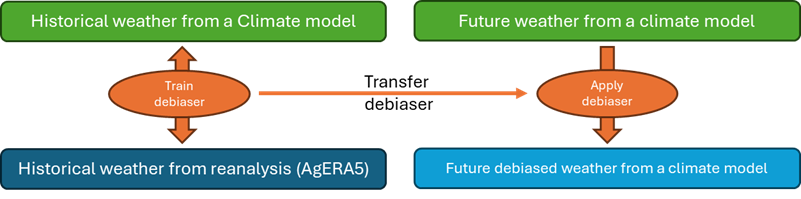

The bias adjustment procedure is carried out by the [IBICUS package](https://ibicus.readthedocs.io/en/latest/index.html) from ECMWF. For more information see the [training notebooks](https://github.com/ecmwf-projects/ibicus/blob/main/notebooks/01%20Getting%20Started.ipynb) that are available for IBICUS. Note that a considerable part of this notebook is dedicated to performing this bias adjustment because it involves several steps including regridding, unit conversion and data format conversion.

Now that we have downloaded the data, we need to make sure that observations and climate model data are:

- on the same temporal resolution: this is covered because we downloaded the data on daily resolution.
- on the same spatial resolution. CMIP6 climate projects have 0.5 degree spatial resolution while AgERA5 has a spatial resolution of 0.1 degree. We thus need to regrid the data.
- in the same units: we may need to convert units.

Furthermore we might want to extract additional information and need to make sure that all data have the form `[t,x,y]`.


### 3A. Load data with IRIS

We will use the `iris` package for the regridding the AgERA5 data towards the spatial resolution of the CMIP6 climate projections. 

First we will need to define the location of the CMIP6 files with climate projection data.

In [10]:
# ---- HISTORICAL CLIMATE PROJECTION DATA DIRECTORIES ----
hist_model_tmean_path = hist_model_path / "near_surface_air_temperature_historical_ec_earth3_cc_extracted" / "tas_day_EC-Earth3-CC_historical_r1i1p1f1_gr_20050101-20091231.nc"
hist_model_prec_path = hist_model_path / "precipitation_historical_ec_earth3_cc_extracted" / "pr_day_EC-Earth3-CC_historical_r1i1p1f1_gr_20050101-20091231.nc"

# ---- FUTURE CLIMATE PROJECTION DATA DIRECTORIES ----
future_model_tmean_path = future_model_path / "near_surface_air_temperature_future_ec_earth3_cc_ssp5_8_5_extracted" / "tas_day_EC-Earth3-CC_ssp585_r1i1p1f1_gr_20400101-20401231.nc"
future_model_prec_path = future_model_path / "precipitation_future_ec_earth3_cc_ssp5_8_5_extracted" / "pr_day_EC-Earth3-CC_ssp585_r1i1p1f1_gr_20400101-20401231.nc"

# ---- HISTORICAL REANALYSIS DATA FROM AGERA5 ----
hist_obs_tmean_path = hist_obs_path / "2m_temperature_24_hour_mean_historical_obs_extracted"
hist_obs_prec_path = hist_obs_path / "precipitation_flux__historical_obs_extracted"

 Next we will use iris to load the CMIP6 files with climate projection data.

In [11]:
# --- Mean daily temperature ---
cm_hist_tmean = iris.load_cube(hist_model_tmean_path, "tas")
cm_future_tmean = iris.load_cube(future_model_tmean_path, "tas")

# --- Daily precipitation ---
cm_hist_prec = iris.load_cube(hist_model_prec_path, "pr")
cm_future_prec = iris.load_cube(future_model_prec_path, "pr")

Next we will load AgERA5 data with `iris` as well. Because AgERA5 consists of individual daily files with a higher spatial resolution this will take a few minutes.

In [12]:
# Method used to unify a list of datacubes to prepare them for merging
def unify_cubes(cubes):
    iris.util.unify_time_units(cubes)
    for raw_cube in cubes:
        for attr in ['creation_date', 'tracking_id', 'history', 'CDI', 'CDO']:
                if attr in raw_cube.attributes:
                    del raw_cube.attributes[attr]
                    
# --- Mean daily temperature from AgERA5 ---
obs_tmean_files = [fname for fname in sorted(hist_obs_tmean_path.iterdir())]
obs_tmean_cubes = iris.cube.CubeList([iris.load_cube(file) for file in obs_tmean_files])
unify_cubes(obs_tmean_cubes)
obs_tmean = obs_tmean_cubes.concatenate_cube() 
obs_tmean.coord('longitude').guess_bounds()
obs_tmean.coord('latitude').guess_bounds()

# --- Daily precipitation from AgERA5 ---
obs_prec_files = [fname for fname in sorted(hist_obs_prec_path.iterdir())]
obs_prec_cubes = iris.cube.CubeList([iris.load_cube(file) for file in obs_prec_files])
unify_cubes(obs_prec_cubes)
obs_prec = obs_prec_cubes.concatenate_cube() 
obs_prec.coord('longitude').guess_bounds()
obs_prec.coord('latitude').guess_bounds()

Unfortunately, the CMIP6 NetCDF files do not have a projection specified for the coordinate system. We need to specify this to be compatible with AgERA5 v2.0. Moreover, we need to compute the boundary coordinates of the cells within the grid with `guess_bounds()` which is required by the regridding.

In [13]:
latlon_cs = iris.coord_systems.GeogCS(semi_major_axis=6378137.0, semi_minor_axis=6356752.314245179)
for iris_cube in [cm_hist_tmean, cm_future_tmean, cm_hist_prec, cm_future_prec]:
    # This adds the coordinate reference system definition
    iris_cube.coord('latitude').coord_system = latlon_cs
    iris_cube.coord('longitude').coord_system = latlon_cs
    # Setting bounds is necessary for area-weighted regridding
    iris_cube.coord('latitude').bounds = None
    iris_cube.coord('latitude').guess_bounds()
    iris_cube.coord('longitude').bounds = None
    iris_cube.coord('longitude').guess_bounds()

### 3B. Regridding with iris

Finally, we can run the regridding. Different variables might require different [regridding schemes](https://scitools-iris.readthedocs.io/en/latest/userguide/interpolation_and_regridding.html?highlight=interpolate#regridding). In this case, we choose an area-weighted regridder.

In [14]:
# Select and initialize the regrid method
regrid_method = iris.analysis.AreaWeighted(mdtol=0.5)

# Apply the regridder to  temperature and precipitation
obs_tmean_regridded = obs_tmean.regrid(cm_hist_tmean, regrid_method)
obs_prec_regridded = obs_prec.regrid(cm_hist_prec, regrid_method)


#### Extract additional information

The data objects are now all at the same temporal and spatial resolution. Because some debiasers need the dates as input, it is useful to extract them here:

In [15]:
@np.vectorize
def get_dates(x):
    "Return dates for data cube X"
    time_dimension = x.coords()[0]
    dates = time_dimension.units.num2date(time_dimension.points)
    return dates
    
dates_cm_hist_tmean = get_dates(cm_hist_tmean)
dates_cm_future_tmean = get_dates(cm_future_tmean)

dates_cm_hist_prec = get_dates(cm_hist_prec)
dates_cm_future_prec = get_dates(cm_future_prec)

dates_obs_tmean = get_dates(obs_tmean_regridded)
dates_obs_prec = get_dates(obs_prec_regridded)

### 3C. Conversion of units

The units of the precipitation data do not match between CMIP6 (kg/m<sup>2</sup>/s) and AgERA5 (mm/d). We convert the AgERA values to match the CMIP6 format.

In [16]:
# Converting precipitation units from mm/d to kg/m2/s
obs_prec_regridded = obs_prec_regridded / 86400

#### Check shapes of inputs

We look at the shapes to make sure they are all in the form `[t, x, y]` and have the same `x` and `y` coordinates:

In [17]:
print(f"Shape cm_hist: {cm_hist_tmean.shape}")
print(f"Shape cm_future: {cm_future_tmean.shape}")
print(f"Shape obs_era5: {obs_tmean_regridded.shape}")

Shape cm_hist: (1826, 12, 16)
Shape cm_future: (366, 12, 16)
Shape obs_era5: (1826, 12, 16)


### 3D. Bias adjusting the climate projection

After these preparations we can finally apply a bias adjustment method. In this illustrative example, we use the quantile mapping methodology to debias temperature values, and the ISIMIP methodology to debias precipitation.


In [18]:
from ibicus.debias import QuantileMapping, ISIMIP

# We use quantile mapping for bias adjustment of temperature
debiaser_tmean = QuantileMapping.from_variable("tas")
# We use the ISIMIP methodology for precipitation
debiaser_prec = ISIMIP.from_variable("pr")

# apply debiaser for temperature ....
print("Bias adjusting temperature data:")
debiased_cm_future_tmean = debiaser_tmean.apply(
    obs_tmean_regridded.data, 
    cm_hist_tmean.data, 
    cm_future_tmean.data, 
    time_obs = dates_obs_tmean, 
    time_cm_hist = dates_cm_hist_tmean, 
    time_cm_future = dates_cm_future_tmean,
    failsafe=True
)

# apply debiaser for precipitation ....
print("Bias adjusting precipitation data:")
debiased_cm_future_prec = debiaser_prec.apply(
    obs_prec_regridded.data, 
    cm_hist_prec.data, 
    cm_future_prec.data, 
    time_obs = dates_obs_prec, 
    time_cm_hist = dates_cm_hist_prec, 
    time_cm_future = dates_cm_future_prec,
    failsafe=True
)

Bias adjusting temperature data:


100%|██████████████████████████████████████████████████████████████████████████████| 192/192 [00:00<00:00, 3366.22it/s]


Bias adjusting precipitation data:


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [08:02<00:00,  2.51s/it]


#### Visualise debiasing effects on temperature

After the debiased climate projection values have been generated, we can visualise them and examine the effect of the debiaser.

The debiased values are stored in a `[t, x, y]` matrix. Let's select one specific grid cell to visualise:

In [19]:
x_vis = 2
y_vis = 2

The code below generates a time-series plot with the bias-adjusted data in orange and the original data in blue.

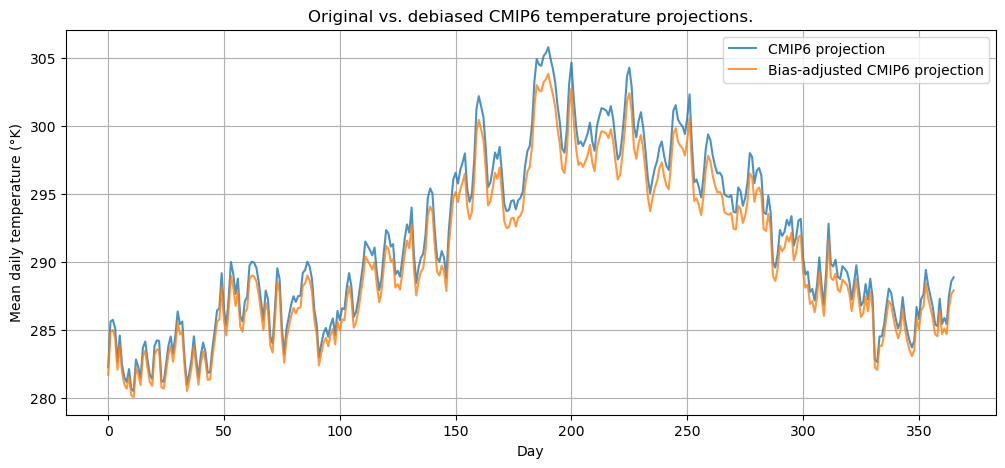

In [20]:
# Visualising temperature bias correction
plt.figure(figsize=(12,5))
plt.title("Original vs. debiased CMIP6 temperature projections.")
plt.plot(cm_future_tmean.data[:, x_vis, y_vis], alpha=0.8, label="CMIP6 projection")
plt.plot(debiased_cm_future_tmean[:, x_vis, y_vis], alpha = 0.8, label="Bias-adjusted CMIP6 projection")
plt.xlabel("Day")
plt.ylabel("Mean daily temperature (°K)")
plt.legend()
plt.grid()
plt.show()

The figure above demonstrates that the climate model tends to overestimate daily mean temperature particularly during the summer period. This can have an impact on the number of warm days computed by the ICCLIM library.

#### Visualise debiasing effects on precipitation

The code below generates the precipitation time-series. 

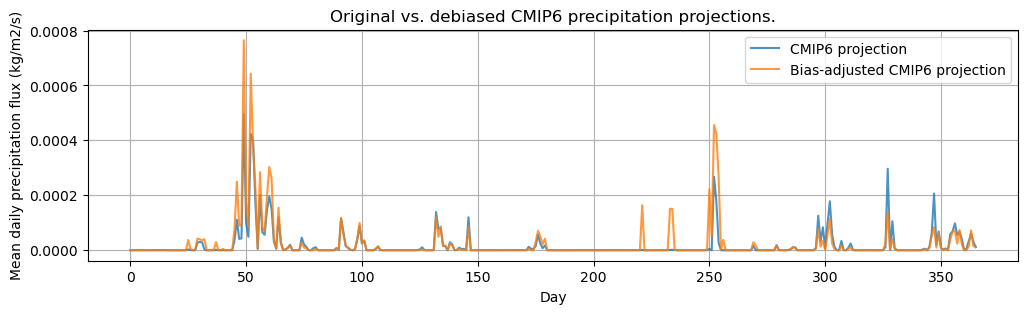

In [21]:
# Visualising precipitation bias correction
plt.figure(figsize=(12,3))
plt.title("Original vs. debiased CMIP6 precipitation projections.")
plt.plot(cm_future_prec.data[:, x_vis, y_vis], alpha=0.8, label="CMIP6 projection")
plt.plot(debiased_cm_future_prec[:, x_vis, y_vis], alpha = 0.8, label="Bias-adjusted CMIP6 projection")
plt.xlabel("Day")
plt.ylabel("Mean daily precipitation flux (kg/m2/s)")
plt.legend()
plt.grid()
plt.show()

The results demonstrate that 
precipitation is both underestimated (around day 50) as well as overestimated (day 250 to 350) by the climate projection.

## 4. Generating agroclimatic indicators

Generating the agroclimatic indicators is relatively straightforward when all the preprocessing steps have been carried out. The [ICCLIM](https://icclim.readthedocs.io/en/stable/index.html) package takes care of the calculation of the agroclimatic indicator and many other climatic indicators are defined there as well.

Now we have bias-adjusted daily temperature and precipitation flux from the climate model for both the historical and future projection. These two climate variables are necessary to compute the "Warm and wet days" (WW) indicator.

**Creating xarray objects**

Unfortunately, the `icclim` library requires xarray inputs for agroclimatic variable computation. Therefore, we need to convert the iris cubes and create an xarray dataset with the debiased values.

In [22]:
# Store data in a chunked dask array
tmean_debiased_data = dask.array.from_array(np.ma.masked_array(debiased_cm_future_tmean, mask = np.isnan(debiased_cm_future_tmean)))
prec_debiased_data = dask.array.from_array(np.ma.masked_array(debiased_cm_future_prec, mask = np.isnan(debiased_cm_future_prec)))

# Load reference datasets for copying coordinates and attributes from
tmean_ref_ds = xr.open_dataset(future_model_tmean_path)
prec_ref_ds = xr.open_dataset(future_model_prec_path)

# Create xarray dataset for debiased values
debiased_ds = xr.Dataset(
    data_vars=dict(
        tas_debiased=(["time", "lat", "lon"], tmean_debiased_data, tmean_ref_ds['tas'].attrs),
        pr_debiased=(["time", "lat", "lon"], prec_debiased_data, prec_ref_ds['pr'].attrs),
        time_bnds = tmean_ref_ds.time_bnds,
        lat_bnds = tmean_ref_ds.lat_bnds,
        lon_bnds = tmean_ref_ds.lon_bnds
    ),
    coords=dict(
        time=tmean_ref_ds.time,
        lon=tmean_ref_ds.lon,
        lat=tmean_ref_ds.lat,
        height= tmean_ref_ds.height
    ),
    attrs=tmean_ref_ds.attrs
)

### 4A. Compute the Warm and wet days (WW) indicator

We can now compute the Water and Wet Days indicator for the future and historical climate period based on the bias-adjusted data from the climate model.

In [23]:
# Compute W&W indicator for the bias-adjusted climate projection
ww = icclim.index(
    index_name="WW",
    in_files=debiased_ds,
    var_name=["tas_debiased", "pr_debiased"]
)

hist_tmean_ds = xr.open_dataset(hist_model_tmean_path)
hist_prec_ds = xr.open_dataset(hist_model_prec_path)

# Compute W&W indicator for the historical climate
ww_hist = icclim.index(
    index_name="WW",
    in_files=[hist_tmean_ds, hist_prec_ds],
    var_name=["tas", "pr"]
)

### 4B. Analysing the results

The code below generates two maps showing the number of warm and wet days going from zero (dark blue) to yellow (15).

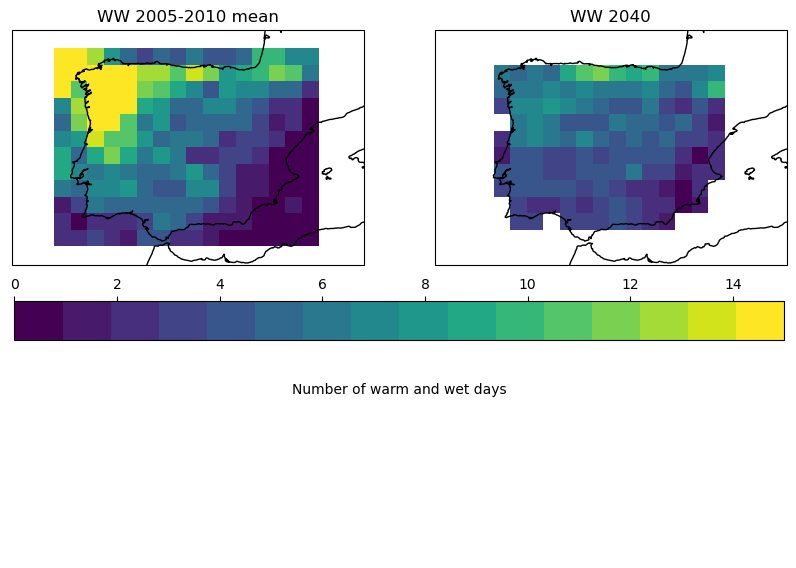

In [24]:
# Helper function to visualise the results of a specific indicator
def visualise_index(index_ds, index_variable, figure_title, ax, cbar_ax, mask_values=None, cmin = None, cmax = None):
    index_data = index_ds[index_variable]
    if index_data.shape[0] > 1:
        index_data_agg = index_data[[-1]]
        index_data_agg[0].values = index_data.mean(dim='time').values
        index_data = index_data_agg
    if mask_values:
        for mask_value in mask_values:
            index_data = index_data.where(index_data != mask_value)
        
    # This is the map projection we want to plot *onto*
    map_proj = ccrs.Mercator()
    
    cmap = plt.get_cmap("viridis", 16)
    p = index_data[0].plot(
        transform=ccrs.PlateCarree(),  # the data's projection
        ax=ax,
        cmap=cmap,
    )  # the plot's projection

    # Set colour limits of the quadmesh
    p.set_clim((cmin, cmax))

    # Set other plot parameters
    ax.coastlines()
    ax.set_extent([AREA[1]-2,AREA[3]+2, AREA[0]+1, AREA[2]-1])
    ax.set_title(figure_title)

    # Keep the colorbar for a separate axis
    p.colorbar.remove()
    if cbar_ax:
        label = "Number of warm and wet days"
        plt.text(0.5,0.8, label, wrap=True, ha='center')
        plt.colorbar(p, ax=cbar_ax, label=None, location='top')

# Set up subplots
fig, geo_axes = plt.subplots(
                    nrows=2, ncols=2,
                    subplot_kw={'projection': ccrs.PlateCarree()},
                    gridspec_kw={'hspace': 0.1},
                    figsize=(10, 7)
                )

gs = geo_axes[1, 0].get_gridspec()
geo_axes[1,1].remove()
geo_axes[1,0].remove()
axbig = fig.add_subplot(gs[1, :])
axbig.set_axis_off()
0
# Visualise indicators
visualise_index(ww_hist, 'WW', "WW 2005-2010 mean", ax=geo_axes[0,0], cbar_ax = None, cmin = 0, cmax = 15)
visualise_index(ww, 'WW', "WW 2040", ax=geo_axes[0,1], cbar_ax = axbig, cmin = 0, cmax = 15)
plt.show()

The two maps shown above clearly demonstrate a decrease in the number of warm and wet days for the Iberian peninsula for the period around 2040. This is often advantageous for crops because they are less impacted by fungal diseases and less spraying is required to protect the plants. This reduces the operational costs for the farmer and the environmental impact of funghicides. Nevertheless, as stated in the introduction, this analysis should be repeated with longer time periods and multiple climate models in order to assess the uncertainty of this result. Moreover, the current values are computed over the entire year and not within the cropping calendar when a crop is on the field. 

The results from the Warm and Wet indicator just represent one aspect of the impact of climate change on cropping systems. Although the change in the WW indicator seem positive there are many other aspects that could negatively impact the cropping system. These include a decrease in length of growing season due to higher temperatures, a decrease in rainfall and an increase in the number of days with extremely high temperatures that can generate damage on crops. To obtain a more holistic picture of the overall impact of climate change, the analysis demonstrated in this notebook should be repeated for other agroclimatic indicators that can provide such insights.


## Take home message

- Agroclimatic indicators can efficiently summarize the agroclimatic conditions during the growing season
- Climate change has an impact on agriculture and agroclimatic indicators help to understand the changes in the environment and their impact on crops.
- The analysis should be refined by defining cropping calendars and computing indicators over the crop cycle rather than the entire year.
- The ICCLIM package provides a range of agroclimatic indicators that can be used to assess the impact of climate change.
- An ensemble of models and a longer time-series is required to capture the variability in time and between climate models which is necessary to assess the uncertainty of an agroclimatic indicator under climate change.
- Calculating agroclimatic indicators is a resource intensive tasks. Repeating this exercise for a large area, a number of climate models and a long time-series requires considerable computational resources. 
- The C3S Copernicus Climate datastore provides most datasets necesssary to calculate agroclimatic indicators and make an assessment of climate change on agriculture.